<center>

# R для тервера и матстата
## Максимальное правдоподобие

<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_4/M_MPlain_grande.png" height="200" width="350"> 





--------

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2020). Автор ноутбука - [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://github.com/FUlyankin/r_probability) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

------

В прошлый раз мы с вами поговорили точечные оценки, их свойства и доверительные интервалы. Также мы немного вспомнили метод моментов, который помогает эти самые точечные оценки получать. Сегодня мы во всех подробностях обсудим другой метод получения точечных оценок, __метод максимального правдоподобия.__

Метод максимального правдоподобия — это основная лошадка современной статистики. Функция правдоподобия встречается абсолютно во всех областях от эконометрики и байесовской статистики до нейронных сетей и рекомендательных систем. Из-за этого очень важно как следует понять как она устроена. В этой тетрадке именно этим мы и займёмся. Итак, сегодня в программе: 

* Что такое метод максимального правдоподобия, вырабатываем интуицию 
* Решаем задачу про конфеты и смотрим на свойства оценок максимального правдоподобия 
* Из метода максимального правдоподобия на нас неожиданно выпрыгивает информация Фишера, разбираемся с тем почему эта штука называется информацией Фишера
* Решаем задачу про M&M's

In [1]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов

# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

In [3]:
# В этом блоке написаны несколько функций, которые рисуют красивые картинки для проверки гипотез.
# Можно не обращать на них внимание :) 

# Область, которую надо будет закрасить на графике 
limitRange <- function(fun, min, max) {
    function(x) {
        y <- fun(x)
        y[x < min  |  x > max] <- NA
        return(y)
    }
}


# Эта страшная функция нужна для карсивых картинок для хи-квадрат распределения
chi_stat_picture <- function(chi_stat, n, alpha =0.05, alternative = 'two-sided'){
    # Опции для размеров графика
    options(repr.plot.width=6, repr.plot.height=3)
    
    # Какие области надо закрасить (зависит от алтиернативы)
    if(alternative == 'two-sided'){
        chi_crit1 <- qchisq(1-(alpha/2), df=n)
        chi_crit2 <- qchisq(alpha/2, df=n)
        dlimit_left  <- limitRange(function(x) dchisq(x, df=n), 0, chi_crit2) 
        dlimit_right <- limitRange(function(x) dchisq(x, df=n), chi_crit1, Inf) 
        }
    if(alternative == 'less'){
        chi_crit2 <- qchisq(alpha,df=n)
        dlimit_left  <- limitRange(function(x) dchisq(x, df=n), 0, chi_crit2)
        dlimit_right <- limitRange(function(x) dchisq(x, df=n), Inf, Inf)        
    }
    if(alternative == 'greater'){
        chi_crit1 <- qchisq(1 - alpha,df=n)
        dlimit_left  <- limitRange(function(x) dchisq(x, df=n), 0, 0)
        dlimit_right <- limitRange(function(x) dchisq(x, df=n), chi_crit1, Inf)
        }        
      
    # Основная картинка
    p <- ggplot(data.frame(x=c(0, qchisq(1-(alpha/2), df=n) + 2)), aes(x = x))+
       stat_function(fun=dchisq, args = list(df=n)) +  # вся функция 
       stat_function(fun=dlimit_left, geom="area",  fill="blue", alpha=0.2) +
       stat_function(fun=dlimit_right, geom="area", fill="blue", alpha=0.2) +
       geom_point(aes(x=chi_stat,y=0), color="red", size=2) +
       geom_vline(xintercept = chi_stat, size=0.3, linetype="dashed", color="red") +
       annotate("text", label=round(chi_stat,2), x= chi_stat, y=0.2, parse=T, size=4, color="darkred")
    
    # Рисуем критические точки 
    if(alternative == 'two-sided'){
       p <- p + annotate("text", label=round(chi_crit1,2), x=chi_crit1+0.1, y=-0.02, parse=T, size=4) + 
                annotate("text", label=round(chi_crit2,2), x=chi_crit2-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'less'){
       p <- p + annotate("text", label=round(chi_crit2,2), x=chi_crit2-0.1, y=-0.02, parse=T, size=4)
        }
    if(alternative == 'greater'){
       p <- p + annotate("text", label=round(chi_crit1,2), x=chi_crit1+0.1, y=-0.02, parse=T, size=4)
        }      
    
    # Немного заключительных настроек, связанных с темой и вывод на экран 
    p <- p + theme(
             axis.text.x = element_blank(),
             axis.text.y = element_blank(),
             axis.ticks = element_blank(),
             axis.title.x = element_blank(),
             axis.title.y = element_blank()
            )
    
    return(p)
}

# 1. Задача про фонтан 

## Задача про фонтан 

* Юра приехал в южный город и увидел, что там есть фонтан и он работает
* Теперь все мысли Юры о том, как часто работает этот фонтан

## Задача про фонтан 

__Гипотезы:__ 

1. Фонтан работает раз в году и нам повезло приехать в правильный день
2. Фонтан работает каждые выходные, а мы как раз приехали в выходные
3. Фонтан работает всегда

<center>
<img src="https://s.tcdn.co/f83/2b2/f832b2ac-6a68-3fd1-96f9-d9ec0e1484b0/5.png" width="150"> 

Мы хотим оценить параметр $\theta$ - работоспособность фонтана. У нас есть в голове несколько гипотез о том, какие именно значения может принимать $\theta$. У нас есть одно наблюдение 

$$x_1 = \text{сегодня фонтан работал}.$$  

Перед нами стоит непосильная задача. Мы должны, руководствуясь этим наблюдением, выбрать для параметра оптимальное значение. Метод максимального правдоподобия подсказывает нам неплохой принцип принятия решения: __что я вижу, то и есть на самом деле.__ Давайте попробуем формализовать этот принцип на языке математики. 

Найдём вероятность получить наблюдение $x_1$ в нашу коллекцию, пройдясь по всем гипотезам. Та гипотеза, при которой эта вероятность будет самой большой - самая правдоподобная. На ней мы и остановимся. Какова вероятность увидеть работающий фонтан именно сегодня, если он работает раз в году? Довольно низкая, всего лишь $\frac{1}{365}$. Потому что дней в году всего $365$, и мы должны приехать в правильный. 

Какова вероятность увидеть работающий фонтан именно сегодня, если он работает только по выходным? В году примерно треть дней - выходные. Значит вероятность составит $\sim \frac{1}{3}$. Кстати говоря, можно записать это как 

$$P(x_1 = \text{работает} \mid \theta = \text{по выходным}).$$  

Какова вероятность увидеть работающий фонтан, если он работает каждый день? Правильно! Это единица. Что у нас получается? Мы нашли вероятность получить наше наблюдение, $P(x_1 \mid \theta)$ при разных значениях $\theta$. Потом мы сказали, что, наверное, самым приемлимым будет такое $\theta$, при котором вероятность увидеть выборку, максимальна и решили задачу 

$$
P(x_1 \mid \theta) \to \max_{\theta}.
$$

Вероятность получить нашу выборку при конкретном значении парметра называется __правдоподобием.__ Мы пытаемся её максимизировать. Поэтому оценка, получаемая на выходе называется __оценкой максимального правдоподобия.__

## Задача про фонтан 

__Гипотезы:__ 

1. Фонтан работает раз в году и нам повезло приехать в правильный день  $\color{red}{\frac{1}{365}}$
2. Фонтан работает каждые выходные, а мы как раз приехали в выходные $\color{red}{\sim \frac{1}{3}}$
3. Фонтан работает всегда $\color{red}{1}$

<center>
<img src="https://s.tcdn.co/f83/2b2/f832b2ac-6a68-3fd1-96f9-d9ec0e1484b0/5.png" width="150"> 

# 2. Правдоподобие и информация Фишера 

Давайте немного формализуем задачу. Для этого я тут продублирую материалы из лекций.


__Выборка выпрыгнула из сундука:__ $x_1, \ldots, x_n$

<br>
<center>
<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_2/yYGiBqtirSM.jpg" width="300"> 
</center> 

Мы не знаем, кто выплюнул на нас её из сундука, но можем предположить, что это случайная величина с полотностью $f(x \mid \theta)$. Про $\theta$ ничего не знаем. Видим выборку, хотим оценить.

Запишем правдоподобие наших данных, то есть вероятность пронаблюдать именно эту выборку: 

$$L( \theta \mid x_1, \ldots, x_n) = f(x_1, \ldots, x_n \mid \theta) = \prod_{i=1}^n f(x_i \mid \theta) \to \max_{\theta}$$

Наша выборка фиксирована. При разных значениях $\theta$ мы получаем большую или меньшую вероятность получить выборку близку к наблюдаемой. Было бы круто найти такое значение $\theta$, для которого эта вероятность оказалась бы максимальной. 

Обратите внимание, что функцию $L( \theta \mid x_1, \ldots, x_n)$ уже нельзя трактовать как плотность распределения. Параметр $\theta$ здесь не рассматривается как случайная величина, он фиксирован. Интеграл $L( \theta \mid x_1, \ldots, x_n)$ по всем возможным значениям $\theta$ не будет равен единице. 

Для максимизации правдоподобия нам придётся брать производные. Куда приятнее их брать от логарифма:

$$
\ln L( \theta \mid x_1, \ldots, x_n) =  \sum_{i=1}^n \ln f(x_i \mid \theta) \to \max_{\theta}
$$

Берём производную и приравниваем её к нулю. 

$$
\frac{\partial \ln L}{\partial \theta} = \sum_{i=1}^n \frac{\partial \ln f(x_i \mid \theta)}{\partial \theta} = 0
$$

Решив это уравнение мы получим оценку максимального правдоподобия. 

Посмотрим на одно слагаемое $\ln f(x_i \mid \theta)$. Его можно интерпретировать как логарифм правдоподобия, посчитанного на основании только одного наблюдения $x_i$.

Когда у нас в выборке появляются новые наблюдения, к нашей функции плюсуется дополнительное слагаемое. Интересно было бы посмотреть на то, как при этом функция изменяется.  У нас есть R. Сгенерируем выборку объёма $5$ из нормального стандартного распределения и посмотрим. 

In [4]:
x <- rnorm(5)
x

[1] -0.2587739  0.1083158 -0.9069983 -1.1540417 -0.3763809

Выпишем для нормального распределения логарифмическую функцию правдоподобия. Она будет зависеть от двух векторов: выборки и параметров.

$$
\ln L(\mu, \sigma^2 \mid x) = -\frac{n}{2}\ln(2\pi)-\frac{n}{2}\ln(\sigma^2)-\sum_{i=1}^n\frac{(x_i - \mu)^2}{2\sigma^2}
$$


Предположим, что $\sigma = 1$, и нам хочется оценить только $\mu$. Перебьём такую функцию в R.

In [5]:
# mu - оцениваемый параметр
# x - вектор данных

log_lik <- function(mu, x) {
  n <- length(x)
  result <- -n/2*log(2*pi)-n/2*log(1)-sum((x-mu)^2)/(2*1)
  return(result)
}

Найдём значение нашей функции в какой-нибудь точке. Какое из значений $\mu$ более правдоподобно?

In [6]:
log_lik(1,x)
log_lik(10,x)

[1] -10.86998

[1] -281.6609

Теперь посмотрим как правдоподобие выглядит на картинке.

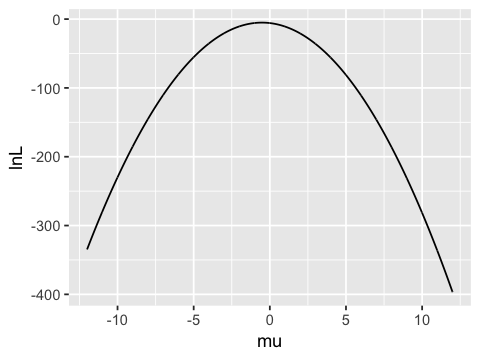

In [7]:
mu  = seq(-12,12,0.01)
lnL = rep(0,length(mu))

for(i in 1:length(lnL)){
    lnL[i] = log_lik(mu[i], x)
}

qplot(mu, lnL, geom='line')

Максимум достигается в районе нуля, но не чётко в нуле.

Построим такие же функции для отдельных наблюдений. 

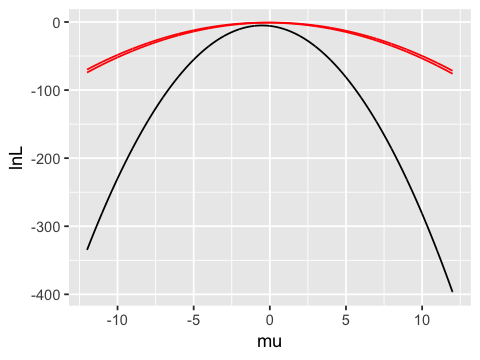

In [8]:
mu  = seq(-12,12,0.01)

lnL = rep(0,length(mu))
lnL1 = rep(0,length(mu))
lnL2 = rep(0,length(mu))

for(i in 1:length(lnL)){
    lnL[i] = log_lik(mu[i], x)
    lnL1[i] = log_lik(mu[i], x[1])
    lnL2[i] = log_lik(mu[i], x[2])
}

df_L = data.frame(mu=mu,lnL = lnL, lnL1 = lnL1, lnL2 = lnL2)

ggplot(df_L, aes(x=mu))+
    geom_line(aes(y=lnL))+
    geom_line(aes(y=lnL1),color='red')+
    geom_line(aes(y=lnL2),color='red')

Черная функция для всей выборки равна сумме логарифмических правдоподобий для отдельных наблюдений (красные линии). У каждого слагаемого своя выпуклость. Чем более выпукло слагаемое, тем более острым оно делает пик при суммировании
Общая функция правдоподобия имеет более выраженный максимум по сравнению с функциями правдоподобия для отдельных наблюдений

Можно построить аналогичную картинку, на которой мы будем постепенно накапливать наблюдения внутри нашей суммы. При добавлении всё новых слагаемых, максимум будет становиться более чётким. 

In [9]:
lnL = rep(0,length(mu))
lnL1 = rep(0,length(mu))
lnL2 = rep(0,length(mu))
lnL3 = rep(0,length(mu))
lnL4 = rep(0,length(mu))
lnL5 = rep(0,length(mu))

for(i in 1:length(lnL)){
    lnL[i] = log_lik(mu[i], x)
    lnL1[i] = log_lik(mu[i], x[1])
    lnL2[i] = log_lik(mu[i], x[1:2])
    lnL3[i] = log_lik(mu[i], x[1:3])
    lnL4[i] = log_lik(mu[i], x[1:4])
}

df_L = data.frame(mu=mu,lnL = lnL, lnL1 = lnL1, lnL2 = lnL2,
                  lnL3 = lnL3,lnL4 = lnL4)

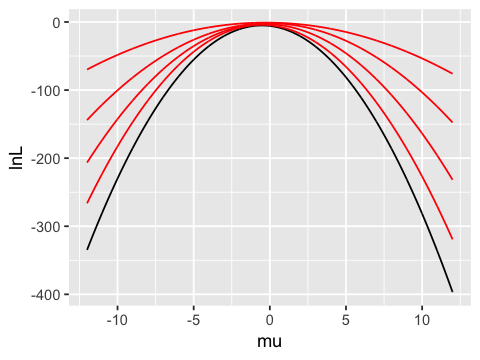

In [10]:
ggplot(df_L, aes(x=mu))+
    geom_line(aes(y=lnL))+
    geom_line(aes(y=lnL1),color='red')+
    geom_line(aes(y=lnL2),color='red')+
    geom_line(aes(y=lnL3),color='red')+
    geom_line(aes(y=lnL4),color='red')

Каждая красная линия - добавление к сумме нового слагаемоего. С каждым слагаемым максимум становится всё более выраженым. Каждое слагаемое добавляет нам информации. Объём этой информации зависит от выпуклости функции правдоподобия для отдельного наблюдения.

Чем более выпукла функция, тем более выражен максимум, тем более сильно мы уверенны в том, что оценка параметра была найдена хорошо.

Что отвечает за выпуклость функции? Правильно! Вторая производная. Именно её, взятую со знаком минус, интерпретируют как наблюдённую информацию.  

$$
I_o(\theta) =  - \left( \frac{\partial^2 \ln L}{\partial \theta^2}  \right)
$$

Почему со знаком минус? Потому что у нас максимум, в точке максимума вторая производная отрицательна. А информация должна быть положительной. Если параметр векторный, то в этом случае наблюдённая информация представляется наблюдённой информационной матрицей: 

$$
I_o(\theta) =  - \left( \frac{\partial^2 \ln L}{\partial \theta_i \partial \theta_j}  \right) = - H
$$

Индекс $"o"$ в данном случае обозначает observed, информацию, которую мы реально видели. В матрице $I_o(\theta)$ во всех клетках стоят числа. Они зависят от конкретных значений наблюдений. 

Обратите внимание, что на первой картинке, правдоподобия, построенные для разных наблюдений выпуклы по разному. Получается, что каждое наблюдение вносит в заострённость нашего правдоподобия разный вклад, то есть в каждом наблюдении содержится разное количество информации. 

Математическое ожидание этой матрицы по распределению $x$ называется информационной матрицей Фишера. 

$$
I(\theta) =  - E\left( \frac{\partial^2 \ln L}{\partial \theta_i \partial \theta_j}  \right) = -E(H)
$$


Ожидаемая информация зависит только от закона распределения наблюдений. Она отражает то, какую информацию в среднем вносит в наше правдоподобие, каждое наблюдение. 

__Если функция плотности $f(x \mid \theta)$ удовлетворяет условиям регулярности__, то тогда для любой несмещённой оценки $\hat \theta$ выполняется неравенство Рао-Фреше-Крамера: 

$$
Var(\hat \theta) \ge [I(\theta)]^{-1}
$$

Более того, в этом случае 

$$
I(\theta) =  - E\left( \frac{\partial^2 \ln L}{\partial \theta^2}  \right) = E\left[ \left( \frac{\partial \ln L}{\partial \theta} \right)^2  \right],
$$

но доказывать это здесь, мы не будем. А вот условия регулярности чуть ниже обсудим. До них нам осталось чуточку потерпеть. __При тех же условиях регулярности,__ оценка максимального правдоподоия обладает набором приятных асимптотических свойств: 

1. Инвариантность, если $\hat \theta$ оценка для $\theta$, то $g(\hat \theta)$ оценка для $g(\theta)$ 
2. Состоятельность 
3. Асимптотическая несмещённость
4. Асимптотическая эффективность
5. Асимптотическая нормальность: 

$$
\hat \theta \to N(\theta, I(\theta)^{-1}) 
$$



Асимптотическую нормальность обычно используют на практике для строительства доверительных интервалов и проверки гипотез. Чтобы сделать это, нужно найти подходящую оценку для информации Фишера, посчитанную на основе выборки. 

Обычно поступают двумя путями: либо заменяют в матрице Гессе, $-H$, все $\theta$ на оценки, либо заменяют в матрице $-E(H)$ все $\theta$ на оценки. Именно так мы с вами поступим, когда будем решать задачки.


__Теперь про условия регулярности.__ Они бывают очень разными. Каждый автор учебника формулирует их по-своему. По большому счёту всё сводится к двум вещам: 

1. Область определения случайной величины не зависит от параметра
2. Можно брать производные и с ними всё хоршо

[В книге Черновой,](https://github.com/FUlyankin/r_probability/raw/master/books/Хороший%20учебник%20по%20матстату.pdf) которую я рекомендую вам полностью прочитать [(её книгу по тереру тоже),](https://github.com/FUlyankin/r_probability/raw/master/books/Хороший%20учебник%20по%20терверу.pdf) требуется, чтобы   $\sqrt{f(x, \theta)}$ была всюду диффириенцируема по $\theta$ и чтобы информация фишера была конечной и существовала. На самом деле можно брать разные условия регулярности и доказывать, что одни следуют из других.

Условия регулярности нужны, чтобы при доказательстве свойств оценок максимального правдоподобия, обходить узкие места. Грубо говоря, в доказательстве нужно взять производную? Она должна существовать. В доказательстве нужно поменять местами интеграл и производную? Давайте ка вспомним какие условия нужны для этого в матане и потребуем их! Не более того. И это как-то скучно. За любой математической конструкцией должна быть какая-то интуиция. Давайте попробуем её нащупать. 

Дело в том, что распределения случайных величин бывают разными. Есть простые, гладкие распределения вроде нормального или экспоненциального. У них есть математические ожидания, производные, область определения не зависит от значения параметра. Из-за этого метод максимального правдоподобия отрабатывает на ура. Если случайная величина устроена сложно, то внутри метода что-то ломается. В таких ситуациях говорят, что столкнулись с __нерегулярным случаем.__ В самом конце пары мы поговорим о равномерном распределении, где есть зависимость области определения случайной величины от оцениваемого параметра. Забавно, что равномерное распределение оказывается сложным с точки зрения условий регулярности. 

# 3. Задача про M&M-сины


<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_4/manams_col.png" height="750" width="750"> 

На картинке ниже находится эм-энд-мсовый тймлайн. Можно посмотреть в какие годы какими были цвета у конфеток.

Я купил несколько упаковок с конфетками и посчитал как часто в них встречаются жёлтые конфетки и красные конфетки. Красных оказалось $46$ штук. Жёлтых $44$ штуки. Остальных цветов $237$ штук. 

Великий и могучий сундук вывалил на меня такие числа. Теперь я хочу узнать что внутри. Я предполагаю, что данные порождались следущей случайной величиной: 

| $X$ | красная | жёлтая | другой цвет   |
|---|---------|--------|---------------|
| $P(X=k)$  |  $p_1$  |  $p_2$ |  $1-p_1 - p_2$|

У нас в выборке есть $X_1$ красных конфеток и $X_2$ жёлтых. $p_1$ и $p_2$ это ненаблюдаемые константы. $X_1$ и $X_2$ это наблюдаемые случайные величины. Наша цель найти $\hat p_1(X_1, X_2)$ и  $\hat p_2(X_1, X_2)$. 

Для этого выписываем функцию правдоподобия! 

$$
L = p_1^{X_1} \cdot p_2^{X_2} \cdot (1-p_1-p_2)^{n-X_1-X_2}
$$

Логарифмируем её:

$$
ln L = X_1 \ln p_1 + X_2 \ln p_2 + (n - X_1 - X_2) \ln(1-p_1-p_2)
$$

Чтобы найти максимум, берём производные!

$$
\begin{cases} 
\frac{\partial \ln L}{\partial p_1} = \frac{X_1}{p_1} - \frac{n-X_1-X_2}{1-p_1-p_2} \\
\frac{\partial \ln L}{\partial p_2} = \frac{X_2}{p_2} - \frac{n-X_1-X_2}{1-p_1-p_2}
\end{cases}
$$

Приравниваем всё это добро к нулю, над буквами $p$ появляются колпачки. С этого момента мы имеем дело с оценками параметров. При настоящих значениях $p$ производные могут быть не равны нулю в доставшихся нам $x_i$. 

В результате решения системы получаем, что 

$$
\begin{cases} 
\hat p_1^{ML} = \frac{X_1}{n} \\
\hat p_2^{ML} = \frac{X_2}{n}
\end{cases}
$$

В общем то это довольно логичный результат. То, что я вижу вне ящика, то и происходит в ящике. Таковы наши оценки. 


Займёмся вторыми производными. Через них найдём оценку информационной матрицы $I$. Это можно сделать двумя способами:

* найти $-H$ и подставить в неё $\hat p$
* найти $-E(H)$  и подставить в неё $\hat p$

Дальше на основе $\hat I$ мы можем найти оценку для $Var(\hat p)$. Эта оценка позволит нам построить для оценок $\hat p$ доверительные интервалы и понять насколько точными получились наши результаты.

Найдём матрицу Гессе:

$$
H = \begin{pmatrix} 
\frac{\partial^2 \ln L}{\partial p_1^2}, \frac{\partial^2 \ln L}{\partial p_1 \partial  p_2} \\
\frac{\partial^2 \ln L}{\partial p_2 \partial p_1}, \frac{\partial^2 \ln L}{\partial p_2^2}
\end{pmatrix}
$$

Сделать это несложно. Нужно просто взять четыре производные. 

$$
H = \begin{pmatrix} 
-\frac{X_1}{p_1^2} - \frac{n-X_1 -X_2}{(1-p_1-p_2)^2}, - \frac{n-X_1 -X_2}{(1-p_1-p_2)^2} \\
- \frac{n-X_1 -X_2}{(1-p_1-p_2)^2}, -\frac{X_2}{p_2^2} - \frac{n-X_1 -X_2}{(1-p_1-p_2)^2}
\end{pmatrix}
$$

Значение $-H$ в точке $\hat p$ будет оценкой информационной матрицы, $\hat I$. Осталось подставить в неё $\hat p$ и обратить. Делать это вручную лениво. Давайте воспользуемся для этого мощью R.

In [11]:
# задаем оценку информационной матрицы руками
# Первый способ - подставим в -H оценки параметров: 
x1 = 46
x2 = 44 
x3 = 237 
n = x1 + x2 + x3

hat.I <- matrix(c(x1/0.14^2+237/0.73^2, 237/0.73^2,
                  237/0.73^2, x2/0.14^2+237/0.73^2),nrow=2)
hat.I

2791.6751,444.7363
444.7363,2689.6343


In [12]:
# считаем обратную --- это будет оценка ковариационной матрицы ошибок
hat.Var <- solve(hat.I)
hat.Var

3.678990e-04,-6.083283e-05
-6.083283e-05,3.818566e-04


Мы получили оценку ковариационной матрицы для наших параметров $\hat p_1$ и $\hat p_2$. На диагонали стоят оценки дисперсий этих параметров, на побочной диагонали стоит ковариация между нашими оценками. 

Построи оценку ковариационной матрицы вторым способом. Для этого найдём $E(H)$. Как мы помним, $X_i \sim Bin(n,p_1)$. Значит $E(X_1) = np_1$. Получается, что: 

$$
E(H) = \begin{pmatrix} 
-\frac{n}{p_1} - \frac{n}{1-p_1-p_2}, - \frac{n}{1-p_1-p_2} \\
- \frac{n}{1-p_1-p_2}, -\frac{n}{p_2} - \frac{n}{1-p_1-p_2}
\end{pmatrix}
$$

Подставими в матрицу $\hat p$ и обратим её.

In [13]:
# Второй способ - подставим в -E(H) оценки параметров: 
hat.I <- matrix(c(n/0.14 + n/0.73, n/0.73,
                  n/0.73, n/0.14 + n/0.73),nrow=2)
hat.I

2783.6595,447.9452
447.9452,2783.6595


In [14]:
# считаем обратную --- это будет оценка ковариационной матрицы ошибок
hat.Var <- solve(hat.I)
hat.Var

3.687892e-04,-5.934538e-05
-5.934538e-05,3.687892e-04


__Вопрос:__ являются ли оценки зависимыми?

# 4. Пакет maxLik

Это милый результат, но он довольно ручной. Мне бы хотелось теперь проделать все те же изыскания в R от начала до конца. Для этого будем использовать пакет `maxLik`. 

Выписываем нашу логарифмическую функцию правдоподобия. Она будет зависеть от двух аргументов: выборки и параметров, которые нужно оценить. В дальнейшем нам нужно максимизировать функцию правдоподобия.

In [15]:
# install.packages('maxLik')  # если пакет не установлен
library('maxLik') # пакет для метода макс. правдоподобия

# Логарифмическое правдоподобие
lnL <- function(p,X) {
    ans <- X[1]*log(p[1])+X[2]*log(p[2])+ (X[3])*log(1-p[1]-p[2])
  return(ans)
}

# Задаём точку для старта, а также выборку, которая пойдёт на вход lnL
res <- maxLik(lnL, start=c(0.1,0.1), X=c(44, 46, 237))

Loading required package: miscTools

Please cite the 'maxLik' package as:
Henningsen, Arne and Toomet, Ott (2011). maxLik: A package for maximum likelihood estimation in R. Computational Statistics 26(3), 443-458. DOI 10.1007/s00180-010-0217-1.

If you have questions, suggestions, or comments regarding the 'maxLik' package, please use a forum or 'tracker' at maxLik's R-Forge site:
https://r-forge.r-project.org/projects/maxlik/


In [16]:
summary(res) # краткий отчет о результатах оценивания

# первый столбик --- сами оценки по методу максимального правдоподобия
# второй столбик --- оценки стандартных ошибок
# т.е. корни из диагональных элементов оценённой ковариационной матрицы
# в третьем и четвёртом столбиках проверятся гипотеза о равенстве этих параметров нулю,
# но об этом позже :)

--------------------------------------------
Maximum Likelihood estimation
Newton-Raphson maximisation, 4 iterations
Return code 1: gradient close to zero
Log-Likelihood: -254.7649 
2  free parameters
Estimates:
     Estimate Std. error t value  Pr(> t)    
[1,]  0.13456    0.01887   7.130 1.00e-12 ***
[2,]  0.14067    0.01923   7.316 2.55e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
--------------------------------------------

In [17]:
# можно вытащить протокол из summary в табличку
result_table = summary(res) 
result_table$estimate

Estimate,Std. error,t value,Pr(> t)
0.1345566,0.01887130,7.130222,1.002075e-12
0.1406728,0.01922697,7.316428,2.546578e-13


In [18]:
# можно вытащить ещё чего-нибудь эдакого
result_table$loglik 

[1] -254.7649

In [19]:
p = res$estimate  # оценки
p

[1] 0.1345566 0.1406728

In [20]:
res$hessian # оценка матрицы Гессе

-2881.3361,-451.1946
-451.1946,-2775.7210


In [21]:
p_var = solve(-1*res$hessian)  # оценка ковариационной матрицы оценок
p_var

3.561261e-04,-5.788845e-05
-5.788845e-05,3.696765e-04


__Упражнение:__ Давайте же построим асимптотический доверительный интервал для $\hat p_1$:

In [22]:
alpha = 0.05
z_alpha = qnorm(1 - alpha/2)

p[1] - z_alpha*sqrt(p_var[1,1])
p[1] + z_alpha*sqrt(p_var[1,1])

[1] 0.0975695

[1] 0.1715437

__Упражнение:__ как построить доверительный интервал для разницы $\hat p_1 - \hat p_2$? 

$$
Var( \hat p_1 - \hat p_2) = Var(\hat p_1) + Var(\hat p_2) + 2 Cov(\hat p_1, -\hat p_2) =  Var(\hat p_1) + Var(\hat p_2) - 2 Cov(\hat p_1, \hat p_2)
$$

In [23]:
diff_std = sqrt(p_var[1,1] + p_var[2,2] - 2*p_var[1,2])
diff = p[1] - p[2]

diff - z_alpha*diff_std
diff + z_alpha*diff_std

[1] -0.06297474

[1] 0.05074233

Ноль попал в доверительный интервал. Что это, означает? 

# Что мы сегодня осознали? 

* Метод максимального правдоподобия - что я вижу, то и есть на самом деле.  
* Производные содержут в себе информацию и именно они используются для её передачи в современной статистике и машинном обучении. Например, вторая производная функции правдоподобия говорит о том, насколько ярко выражен пик правдоподобия. 
* Информация Фишера говорит о острие пика, это усреднённая по выборке вторая производная, взятая со знаком минус (потому что мы максимизируем правдоподобие, в оптимуме вторая производная отрицательна, надо это компенсировать ещё одним минусом).
